# Práctica 2: Calibración de un Detector Centelleador

Está orientada esta práctica a los sistemas de calibración de un centelleador de NaI (3 x 3) en fuentes gamma con fondo ambiental. Se estudiaran 3 espectros de fuentes de rayos gamma de $^{22}Na$, $^{60}Co$ y $^{137}Cs$ fueron colocadas, una a una, sobre la nariz del detector durante los tiempos de toma de datos $/Delta t$ listados en la Tabla. En esta misma Tabla están listados los archivos con los espectros resultantes.

| fuente $/gamma$ | $/Delta$ t (min) | archivo           |
|---------------|----------------|-----------------------|
| $^{137}Cs$      | 10              | Cs137_5minNaI.dat     |
| $^{60}Co$       | 10             | NaI_60Co_600s.dat     |
| $^{22}Na$       | 10             | NaI_137Cs_600s.dat     |
| Fondo           | 10             |  NaI_Fondo_600s.dat     |
|---------------|----------------|-----------------------|
| $^{57}Co$       | 5             | NaI_57Co_300s.dat     |
| Fondo      | 5             | NaI_Fondo_300s.dat     |
---------------------------------------------------------



## Previo

Se importan los paquetes y se aplica el formato general


In [1]:
import numpy as np
from scipy.stats import poisson, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as wid
from scipy.optimize import curve_fit
import colorcet as cc
import os
import copy
from matplotlib.patches import FancyBboxPatch
import uncertainties as un

Se configuran las gráficas, tengase en cuenta que algunos pueden no cargar por dependencias a instalar pendientes.


In [2]:
%matplotlib inline
# plt.style.use("seaborn-v0_8-bright")
mpl.rcParams.update(
    {
        "legend.fontsize": 20,
        "axes.labelsize": 24,  # Updated from 20 to 24
        "axes.titlesize": 24,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "figure.titlesize": 24,
        "axes.titlepad": 10,
        "text.usetex": True,
        "font.family": "Times New Roman",
        "mathtext.fontset": "dejavusans",
        "font.size": 20,
        "axes.labelweight": "bold",
        "axes.grid.which": "both",
        "axes.grid": True,
        "grid.alpha": 0.5,
        "axes.formatter.limits": (-3, 3)  # Use scientific notation for values outside the range 10^-3 to 10^3
    }
)

colors = cc.glasbey_dark
# Configuracion de colores
k = 0

# Rotar la lista: número positivo para rotar a la derecha, negativo para rotar a la izquierda
colors = colors[-k:] + colors[:-k]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

# Test
if False:
    plt.figure(figsize=(5, 5))
    plt.plot([1, 2, 3, 4], [1, 4, 9, 16], "o")
    plt.plot([4, 3, 2, 1], [1, 2, 3, 4], "o")
    plt.plot([1, 2, 3, 4], [1, 2, 3, 4], "s")
    plt.plot([4, 3, 2, 1], [1, 4, 9, 16], "s")
    plt.title("Test")
    plt.xlabel("X-axis Label", fontweight="bold")
    plt.ylabel("Y-axis Label")
    plt.show()

## 0. Preparación

Importamos los archivos

In [3]:
# Importar CSVs por pandas
na22 = pd.read_csv("data/NaI_22Na_600s.dat")
co57 = pd.read_csv("data/NaI_57Co_300s.dat")
co60 = pd.read_csv("data/NaI_60Co_600s.dat")
cs137 = pd.read_csv("data/NaI_137Cs_600s.dat")
bg_300s = pd.read_csv("data/NaI_Fondo_300s.dat")
bg_600s = pd.read_csv("data/NaI_Fondo_600s.dat")

data = {
    "bg_600s": {"file": bg_600s, "time_m": 10, "name": "Fondo 10 min"},
    "bg_300s": {"file": bg_300s, "time_m": 5, "name": "Fondo 5 min"},
    "na22": {"file": na22, "time_m": 10, "name": r"$^{22}$Na"},
    "co57": {"file": co57, "time_m": 5, "name": r"$^{57}$Co"},
    "co60": {"file": co60, "time_m": 10, "name": r"$^{60}$Co"},
    "cs137": {"file": cs137, "time_m": 10, "name": r"$^{137}$Cs"},
}
for key, value in data.items():
    df = value["file"]
    df = df["canal\t cuentas"].str.split(expand=True)
    df.columns = ["canal", "cuentas"]
    df["canal"] = df["canal"].astype(int)
    df["cuentas"] = df["cuentas"].astype(int)
    data[key]["file"] = df  # Guardar el dataframe modificado

# test
if True:
    print(data["na22"]["file"].head())

   canal  cuentas
0      0        0
1      1        0
2      2        0
3      3        0
4      4        0


El formato general del archivo es

```"na22": {"file": na22, "time_m": 10, "name": r"$^{22}Na$"}```

### Gráfica Simultanea
Determinar:
- pico más intenso
- pico menos intenso1

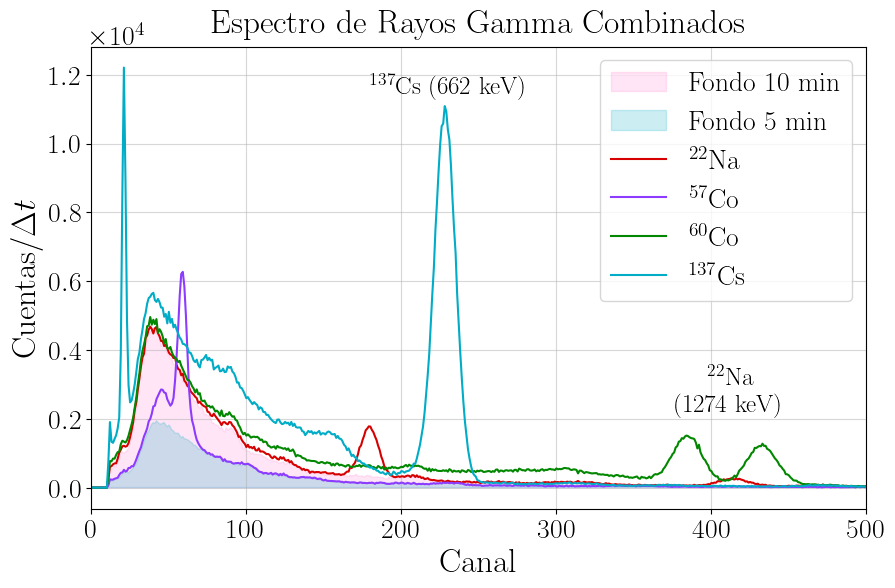

In [4]:
# Gráfica
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Permitir leer y graficar
for key, value in data.items():
    df = value["file"]
    if value["name"] == "Fondo 5 min":
        color = colors[list(data.keys()).index("co57")]
        ax.fill_between(df["canal"], df["cuentas"], alpha=0.2, label=value["name"], color=color)
    elif value["name"] == "Fondo 10 min":
        color = colors[list(data.keys()).index("cs137")]
        ax.fill_between(df["canal"], df["cuentas"], alpha=0.2, label=value["name"], color=color)
    else:
        ax.plot(df["canal"], df["cuentas"], label=value["name"])

ax.text(180, 1.147e+04, "$^{137}$Cs (662 keV)", fontsize=18, color='black', fontweight='bold')
ax.text(412, 2.20e+03, "$^{22}$Na\n(1274 keV)", fontsize=18, color='black', fontweight='bold', ha='center')
ax.set_xlim(0, 500)
ax.set_xlabel("Canal")
ax.set_ylabel(r"Cuentas/$\Delta t$")
ax.set_title("Espectro de Rayos Gamma Combinados")
ax.legend()
fig.savefig("espectro_gamma_combinados.pdf", format='pdf')
plt.show()

Pasar todo a txt

In [5]:
if False:
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Iterate over each item in the data dictionary
    for key, value in data.items():
        df = value["file"]
        df = df["canal\t cuentas"].str.split(expand=True)
        df.columns = ["canal", "cuentas"]
        
        # Save the second column (cuentas) to a .txt file
        output_filepath = os.path.join(output_directory, f"{key}_cuentas.txt")
        df["cuentas"].to_csv(output_filepath, index=False, header=False)

A cada espectro le restamos el fondo

In [6]:
# Gráfica
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data_bg = copy.deepcopy(data)

for key, value in data_bg.items():
    df = value["file"]
    if value["time_m"] == 5:
        fondo = data["bg_300s"]["file"]
    elif value["time_m"] == 10:
        fondo = data["bg_600s"]["file"]
    
    # Restar el fondo
    df["cuentas"] = df["cuentas"] - fondo["cuentas"]
    df["cuentas"] = df["cuentas"].clip(lower=0)  # Asegurarse de que no haya valores negativos
    data_bg[key]["file"] = df

    # Graficar para verificar
    if not(key == "bg_300s" or key == "bg_600s"):
        ax.plot(df["canal"], df["cuentas"], label=value["name"])

ax.set_xlim(0, 500)
ax.set_xlabel("Canal")
ax.set_ylabel(r"Cuentas/$\Delta t$")
ax.set_title("Espectros Sin Fondo Ambiental")
ax.legend()
fig.savefig("espectro_sin_fondo.pdf")
fig.show()

C:\Users\pinzo\AppData\Local\Temp\ipykernel_14528\422928191.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


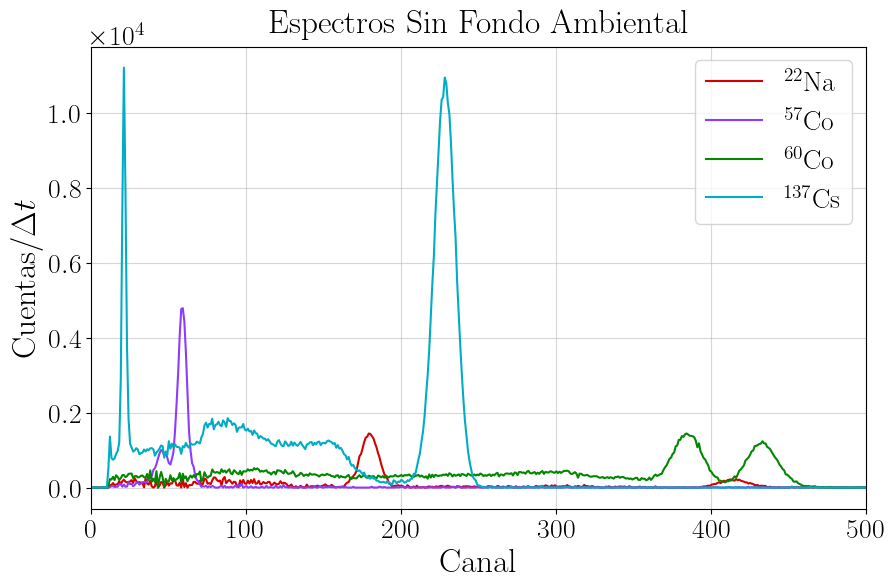

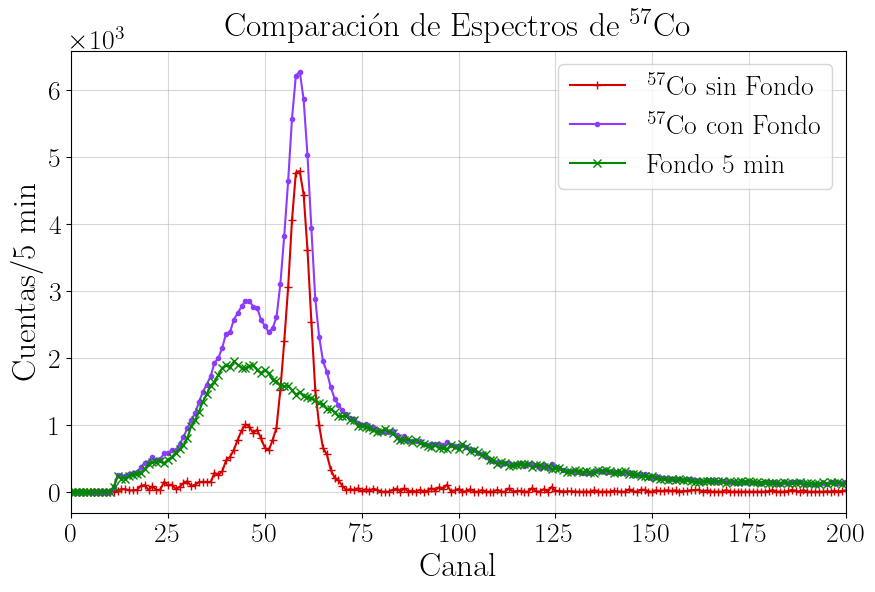

In [7]:
# Solo espectro de 57Co
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df = data_bg["co57"]["file"]
ax.plot(df["canal"], df["cuentas"], label=f'{data_bg["co57"]["name"]} sin Fondo', marker='+')
df_bg = data["co57"]["file"]
ax.plot(df_bg["canal"], df_bg["cuentas"], label=f'{data["co57"]["name"]} con Fondo', marker='.')

# Graficar fondo_300s
df_fondo_300s = data["bg_300s"]["file"]
ax.plot(df_fondo_300s["canal"], df_fondo_300s["cuentas"], label="Fondo 5 min", marker='x')

ax.set_xlim(0, 200)
ax.set_xlabel("Canal")
ax.set_ylabel(f"Cuentas/{data['co57']['time_m']} min")
ax.set_title(r"Comparación de Espectros de $^{57}$Co")
ax.legend()
fig.savefig("espectro_co57_comparacion.pdf", format='pdf')
plt.show()

## 1. Valores Espectroscópicos
Graficar solo las gaussianas

In [8]:
def analisis(element, params_0):
    value = data_bg[element]
    df = value["file"]
    index = list(data_bg.keys()).index(element) - 2

    # Gráfica
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(df["canal"], df["cuentas"], label=value["name"], color=colors[index], marker="x")
    ax.set_xlabel("Canal")
    ax.set_ylabel(f"Cuentas/{value['time_m']} min")
    ax.set_title(f"Espectro  Gamma de {value['name']}")

    # Parameters for the Gaussian
    centroid = params_0["centroid"]
    sigma = params_0["sigma"]
    amplitude = params_0["amplitude"]
    x_range = params_0["x_range"]

    # Define the Gaussian with background function
    def gauss_bg(x, mu, sigma, A, a0, a1):
        return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

    # Fit the Gaussian with background to the data within the specified x_range
    mask = (df["canal"] >= x_range[0]) & (df["canal"] <= x_range[1])
    # Initial guess for the background parameters
    a0_guess = df["cuentas"][df["canal"] == x_range[0]].values[0]
    a1_guess = df["cuentas"][df["canal"] == x_range[1]].values[0]

    # Fit the Gaussian with background to the data within the specified x_range
    popt, pcov = curve_fit(gauss_bg, df["canal"][mask], df["cuentas"][mask], p0=[centroid, sigma, amplitude, a0_guess, a1_guess])

    # Extract the fitted parameters
    uncertainties = np.sqrt(np.diag(pcov))
    fitted_centroid, fitted_sigma, fitted_amplitude, fitted_a0, fitted_a1 = popt
    area = np.sqrt(2 * np.pi) * fitted_amplitude * fitted_sigma
    params = {
        "centroid": np.array([fitted_centroid, uncertainties[0]]),
        "sigma": np.array([fitted_sigma, uncertainties[1]]),
        "amplitude": np.array([fitted_amplitude, uncertainties[2]]),
        "a0": np.array([fitted_a0, uncertainties[3]]),
        "a1": np.array([fitted_a1, uncertainties[4]]),
        "area": np.array([area, np.sqrt(np.diag(pcov)[2] * (2 * np.pi * fitted_sigma)**2 + (fitted_amplitude * np.sqrt(2 * np.pi) * uncertainties[1])**2)])
    }

    # Print the fitted parameters
    print(f"Fitted parameters with uncertainties:\n"
          f"Centroid: {fitted_centroid:.2f} ± {uncertainties[0]:.2f}\n"
          f"Sigma: {fitted_sigma:.2f} ± {uncertainties[1]:.2f}\n"
          f"Amplitude: {fitted_amplitude:.2f} ± {uncertainties[2]:.2f}\n"
          f"a0: {fitted_a0:.2f} ± {uncertainties[3]:.2f}\n"
          f"a1: {fitted_a1:.2f} ± {uncertainties[4]:.2f}\n"
          f"Intensidad bajo la curva Gaussiana: {area:.2f}\n")

    x = np.linspace(x_range[0], x_range[1], 1000)
    # Generate Gaussian values with fitted parameters
    gaussian_with_bg_fitted = gauss_bg(x, *popt)
    # Plot the fitted Gaussian with background
    ax.plot(x, gaussian_with_bg_fitted, label="Ajuste Gaussiano", color='red', linestyle='-')

    # Generate x values for the background line
    x_bg = np.array([x_range[0], x_range[1]])
    # Generate y values for the background line using the fitted background parameters
    y_bg = fitted_a0 + fitted_a1 * x_bg
    # Fill area under the fitted Gaussian with background
    ax.fill_between(x, np.interp(x, x_bg, y_bg), gaussian_with_bg_fitted, alpha=0.2, label="Intensidad", color="red")

    # Fill area under Gaussian with background
    ax.set_xlim(centroid - 9 * sigma, centroid + 5 * sigma)
    ax.legend(loc='center left')
    return fig, ax, params

Fitted parameters with uncertainties:
Centroid: 45.46 ± 0.31
Sigma: 3.41 ± 0.44
Amplitude: 639.25 ± 83.88
a0: -490.51 ± 270.97
a1: 18.25 ± 7.76
Intensidad bajo la curva Gaussiana: 5462.27



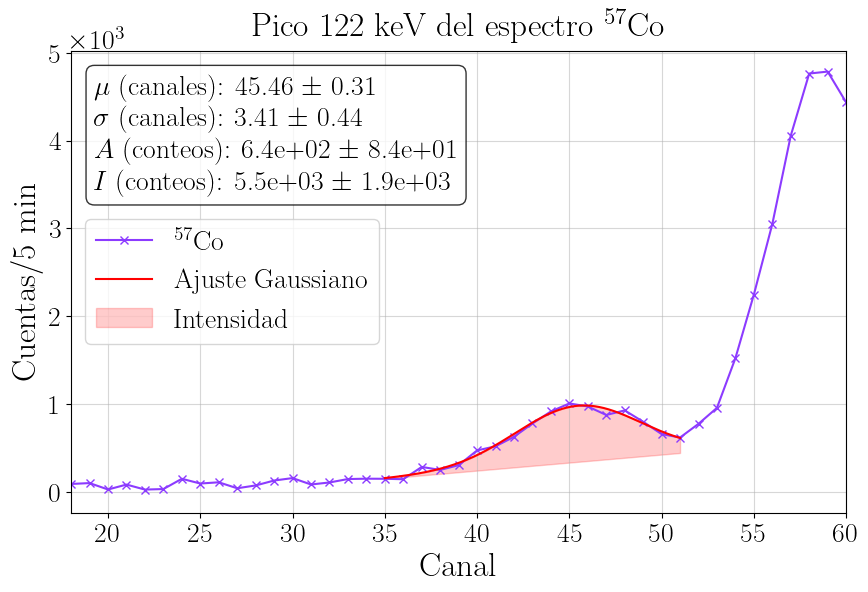

In [9]:
# Gráfica de co57
element = "co57"
params = {
    "centroid": 45,
    "sigma": 3,
    "amplitude": 1000,
    "x_range": [35, 51]
}

fig, ax, param = analisis(element, params)
parametros = (
    fr"$\mu$ (canales): {param['centroid'][0]:.2f} $\pm$ {param['centroid'][1]:.2f}" + "\n"
    fr"$\sigma$ (canales): {param['sigma'][0]:.2f} $\pm$ {param['sigma'][1]:.2f}" + "\n"
    fr"$A$ (conteos): {param['amplitude'][0]:.1e} $\pm$ {param['amplitude'][1]:.1e}" + "\n"
    fr"$I$ (conteos): {param['area'][0]:.1e} $\pm$ {param['area'][1]:.1e}"
)
# Add text with a white background and rounded corners
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(0.03, 0.95, parametros, fontsize=20, color='black', fontweight='bold', transform=ax.transAxes, verticalalignment='top', bbox=bbox_props)
ax.set_title("Pico 122 keV del espectro $^{57}$Co")
fig.savefig("peak122_co57.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 58.74 ± 0.04
Sigma: 2.65 ± 0.05
Amplitude: 4396.52 ± 59.89
a0: 1451.33 ± 360.63
a1: -16.26 ± 5.90
Intensidad bajo la curva Gaussiana: 29188.15



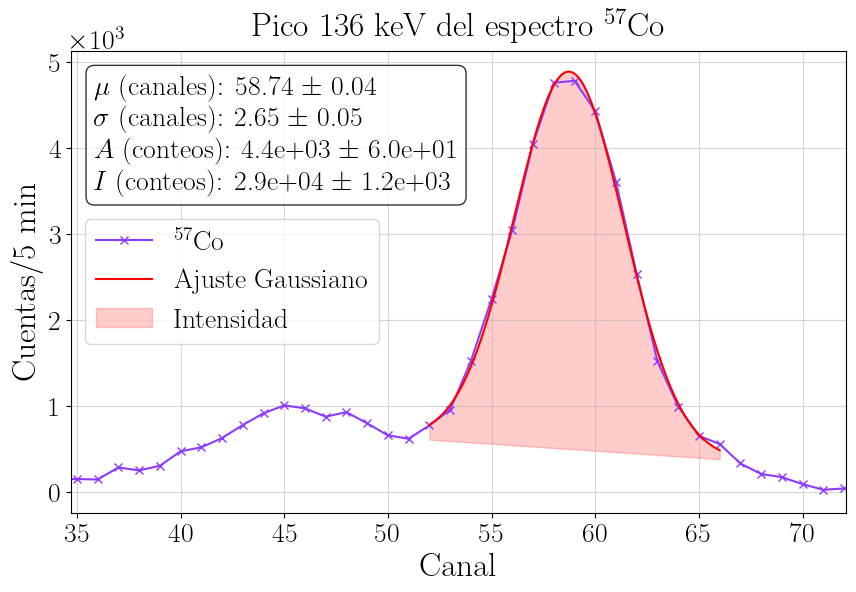

In [10]:
# Gráfica de co57
element = "co57"
params = {
    "centroid": 58.75,
    "sigma": 2.67,
    "amplitude": 4400.5,
    "x_range": [52, 66]
}

fig, ax, param = analisis(element, params)
parametros = (
    fr"$\mu$ (canales): {param['centroid'][0]:.2f} $\pm$ {param['centroid'][1]:.2f}" + "\n"
    fr"$\sigma$ (canales): {param['sigma'][0]:.2f} $\pm$ {param['sigma'][1]:.2f}" + "\n"
    fr"$A$ (conteos): {param['amplitude'][0]:.1e} $\pm$ {param['amplitude'][1]:.1e}" + "\n"
    fr"$I$ (conteos): {param['area'][0]:.1e} $\pm$ {param['area'][1]:.1e}"
)
# Add text with a white background and rounded corners
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(0.03, 0.95, parametros, fontsize=20, color='black', fontweight='bold', transform=ax.transAxes, verticalalignment='top', bbox=bbox_props)
ax.set_title("Pico 136 keV del espectro $^{57}$Co")
fig.savefig("peak136_co57.pdf")
plt.show()

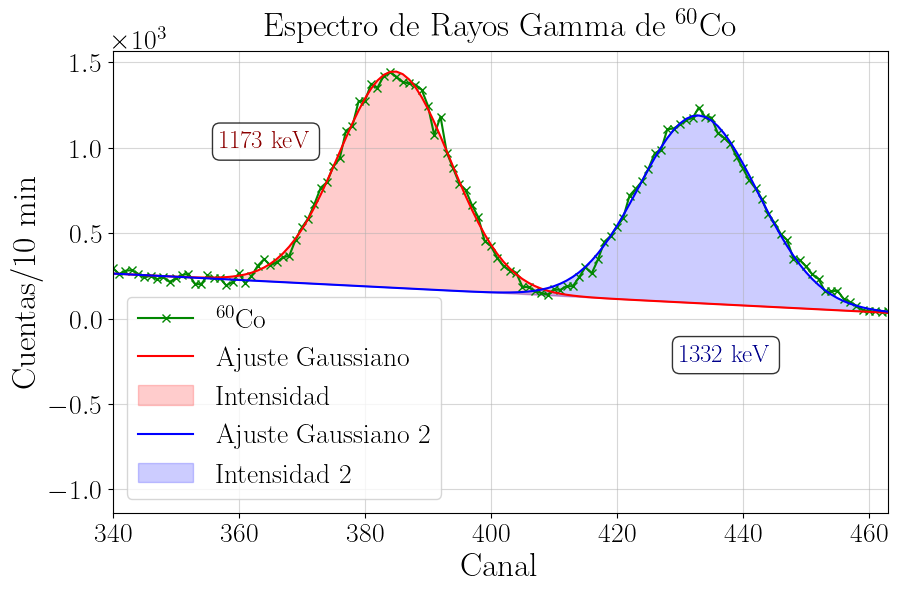

Fitted parameters for the first Gaussian:
Centroid: 384.71
Sigma: 8.82
Amplitude: 1267.07
Area: 28001.00

Fitted parameters for the second Gaussian:
Centroid: 432.94
Sigma: 9.42
Amplitude: 1099.26
Area: 25969.46



In [11]:
# Gráfica de co60
element = "co60"
params1 = {
    "centroid": 384,
    "sigma": 9,
    "amplitude": 1298,
    "x_range": [362, 409]
}

params2 = {
    "centroid": 432,
    "sigma": 9.7,
    "amplitude": 1121,
    "x_range": [411, 458]
}

value = data_bg[element]
df = value["file"]
index = list(data_bg.keys()).index(element) - 2

# Gráfica
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(df["canal"], df["cuentas"], label=value["name"], color=colors[index], marker="x")
ax.set_xlabel("Canal")
ax.set_ylabel(f"Cuentas/{value['time_m']} min")
ax.set_title(f"Espectro de Rayos Gamma de {value['name']}")

# Parameters for the Gaussian
centroid = params1["centroid"]
sigma = params1["sigma"]
amplitude = params1["amplitude"]
x_range = params1["x_range"]

# fondo linea---------------
# Curve fit for a line from values from 318 to 355 and from 459 to 469
mask_bg = ((df["canal"] >= 318) & (df["canal"] <= 355)) | ((df["canal"] >= 459) & (df["canal"] <= 469))
popt_bg, _ = curve_fit(lambda x, a0, a1: a0 + a1 * x, df["canal"][mask_bg], df["cuentas"][mask_bg])

bg_line = popt_bg[0] + popt_bg[1] * df["canal"]
#-------------------------------------------------------
# Define the Gaussian with background function
def gauss_bg(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + popt_bg[0] + popt_bg[1] * x

# Fit the Gaussian with background to the data within the specified x_range
mask = (df["canal"] >= x_range[0]) & (df["canal"] <= x_range[1])
popt, pcov = curve_fit(gauss_bg, df["canal"][mask], df["cuentas"][mask], p0=[centroid, sigma, amplitude])

# Extract the fitted parameters
fitted_centroid, fitted_sigma, fitted_amplitude = popt
gaussian_with_bg_fitted = gauss_bg(df["canal"], *popt)

# Plot the fitted Gaussian with background
ax.plot(df["canal"], gaussian_with_bg_fitted, label="Ajuste Gaussiano", color="red", linestyle="-")
# Fill area under the fitted Gaussian with background
ax.fill_between(df["canal"], bg_line, gaussian_with_bg_fitted, where=(gaussian_with_bg_fitted > bg_line), alpha=0.2, label="Intensidad", color="red")

# Parameters for the second Gaussian
centroid2 = params2["centroid"]
sigma2 = params2["sigma"]
amplitude2 = params2["amplitude"]
x_range2 = params2["x_range"]

# Fit the second Gaussian with background to the data within the specified x_range
mask2 = (df["canal"] >= x_range2[0]) & (df["canal"] <= x_range2[1])
popt2, pcov2 = curve_fit(gauss_bg, df["canal"][mask2], df["cuentas"][mask2], p0=[centroid2, sigma2, amplitude2])

# Extract the fitted parameters for the second Gaussian
fitted_centroid2, fitted_sigma2, fitted_amplitude2 = popt2
gaussian_with_bg_fitted2 = gauss_bg(df["canal"], *popt2)

# Plot the fitted second Gaussian with background
ax.plot(df["canal"], gaussian_with_bg_fitted2, label="Ajuste Gaussiano 2", color="blue", linestyle="-")
# Fill area under the fitted second Gaussian with background
ax.fill_between(df["canal"], bg_line, gaussian_with_bg_fitted2, where=(gaussian_with_bg_fitted2 > bg_line), alpha=0.2, label="Intensidad 2", color="blue")
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(357, 1000, "1173 keV", fontsize=18, color='darkred', fontweight='bold', bbox=bbox_props)
ax.text(430, -250, "1332 keV", fontsize=18, color='darkblue', fontweight='bold', bbox=bbox_props)
ax.legend()
ax.set_xlim(340, 463)
fig.savefig("peaks_co60.pdf")
plt.show()

# Calculate the area under the first Gaussian
area1 = np.sqrt(2 * np.pi) * fitted_amplitude * fitted_sigma

# Print the fitted parameters for the first Gaussian
print(f"Fitted parameters for the first Gaussian:\n"
    f"Centroid: {fitted_centroid:.2f}\n"
    f"Sigma: {fitted_sigma:.2f}\n"
    f"Amplitude: {fitted_amplitude:.2f}\n"
    f"Area: {area1:.2f}\n")

# Calculate the area under the second Gaussian
area2 = np.sqrt(2 * np.pi) * fitted_amplitude2 * fitted_sigma2

# Print the fitted parameters for the second Gaussian
print(f"Fitted parameters for the second Gaussian:\n"
    f"Centroid: {fitted_centroid2:.2f}\n"
    f"Sigma: {fitted_sigma2:.2f}\n"
    f"Amplitude: {fitted_amplitude2:.2f}\n"
    f"Area: {area2:.2f}\n")

Fitted parameters with uncertainties:
Centroid: 228.14 ± 0.03
Sigma: 6.84 ± 0.04
Amplitude: 10677.86 ± 38.58
a0: 1780.18 ± 313.16
a1: -7.38 ± 1.40
Intensidad bajo la curva Gaussiana: 183048.61



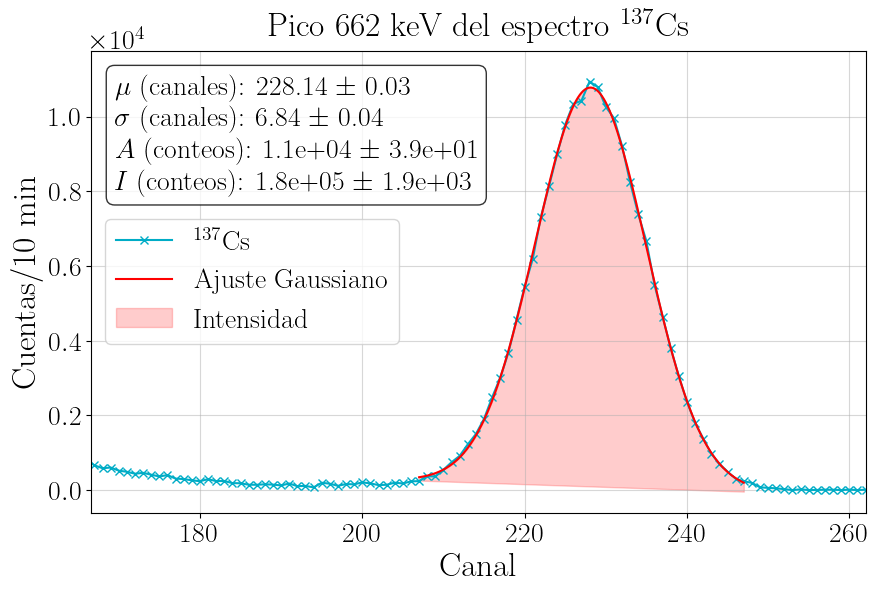

In [12]:
# Gráfica de co57
element = "cs137"
params = {
    "centroid": 228,
    "sigma": 6.82,
    "amplitude": 10598,
    "x_range": [207, 247]
}

fig, ax, param = analisis(element, params)
parametros = (
    fr"$\mu$ (canales): {param['centroid'][0]:.2f} $\pm$ {param['centroid'][1]:.2f}" + "\n"
    fr"$\sigma$ (canales): {param['sigma'][0]:.2f} $\pm$ {param['sigma'][1]:.2f}" + "\n"
    fr"$A$ (conteos): {param['amplitude'][0]:.1e} $\pm$ {param['amplitude'][1]:.1e}" + "\n"
    fr"$I$ (conteos): {param['area'][0]:.1e} $\pm$ {param['area'][1]:.1e}"
)
# Add text with a white background and rounded corners
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(0.03, 0.95, parametros, fontsize=20, color='black', fontweight='bold', transform=ax.transAxes, verticalalignment='top', bbox=bbox_props)
ax.set_title("Pico 662 keV del espectro $^{137}$Cs")
fig.savefig("peak662_cs137.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 21.06 ± 0.03
Sigma: 1.14 ± 0.04
Amplitude: 9905.17 ± 233.58
a0: -17.19 ± 738.55
a1: 55.23 ± 34.71
Intensidad bajo la curva Gaussiana: 28226.98



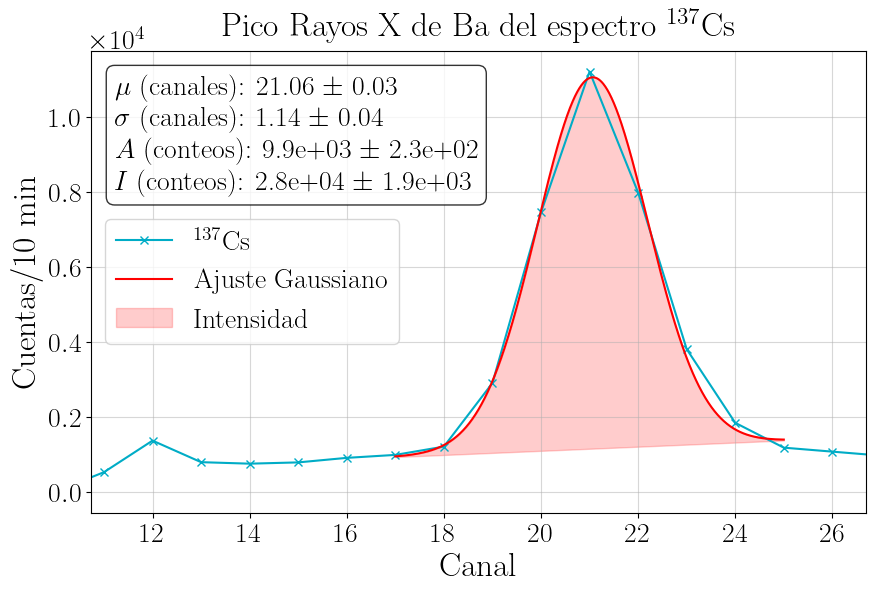

In [13]:
# Gráfica de co57
element = "cs137"
params = {
    "centroid": 21,
    "sigma": 1.14,
    "amplitude": 9899,
    "x_range": [17, 25]
}

fig, ax, param = analisis(element, params)
parametros = (
    fr"$\mu$ (canales): {param['centroid'][0]:.2f} $\pm$ {param['centroid'][1]:.2f}" + "\n"
    fr"$\sigma$ (canales): {param['sigma'][0]:.2f} $\pm$ {param['sigma'][1]:.2f}" + "\n"
    fr"$A$ (conteos): {param['amplitude'][0]:.1e} $\pm$ {param['amplitude'][1]:.1e}" + "\n"
    fr"$I$ (conteos): {param['area'][0]:.1e} $\pm$ {param['area'][1]:.1e}"
)
# Add text with a white background and rounded corners
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(0.03, 0.95, parametros, fontsize=20, color='black', fontweight='bold', transform=ax.transAxes, verticalalignment='top', bbox=bbox_props)
ax.set_title("Pico Rayos X de Ba del espectro $^{137}$Cs")
fig.savefig("peakba_cs137.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 179.46 ± 0.04
Sigma: 5.76 ± 0.04
Amplitude: 1409.97 ± 8.41
a0: 25.08 ± 14.96
a1: -0.00 ± 0.06
Intensidad bajo la curva Gaussiana: 20366.09



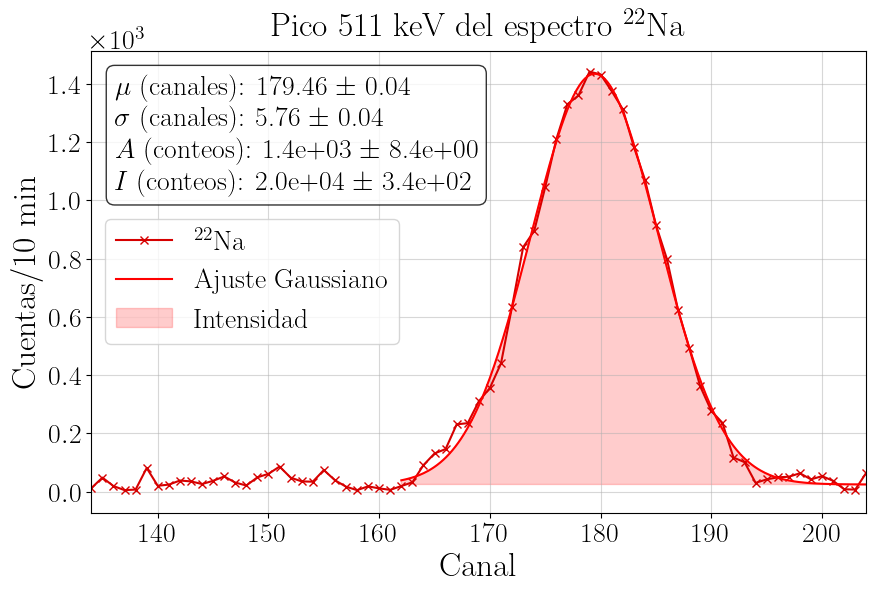

In [14]:
# Gráfica de co57
element = "na22"
params = {
    "centroid": 179,
    "sigma": 5,
    "amplitude": 1424,
    "x_range": [162, 297]
}

fig, ax, param = analisis(element, params)
parametros = (
    fr"$\mu$ (canales): {param['centroid'][0]:.2f} $\pm$ {param['centroid'][1]:.2f}" + "\n"
    fr"$\sigma$ (canales): {param['sigma'][0]:.2f} $\pm$ {param['sigma'][1]:.2f}" + "\n"
    fr"$A$ (conteos): {param['amplitude'][0]:.1e} $\pm$ {param['amplitude'][1]:.1e}" + "\n"
    fr"$I$ (conteos): {param['area'][0]:.1e} $\pm$ {param['area'][1]:.1e}"
)
# Add text with a white background and rounded corners
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(0.03, 0.95, parametros, fontsize=20, color='black', fontweight='bold', transform=ax.transAxes, verticalalignment='top', bbox=bbox_props)
ax.set_title("Pico 511 keV del espectro $^{22}$Na")
fig.savefig("peak511_na22.pdf")
plt.show()

Fitted parameters with uncertainties:
Centroid: 414.05 ± 0.27
Sigma: 9.54 ± 0.39
Amplitude: 206.44 ± 5.90
a0: -120.26 ± 72.30
a1: 0.30 ± 0.17
Intensidad bajo la curva Gaussiana: 4936.02



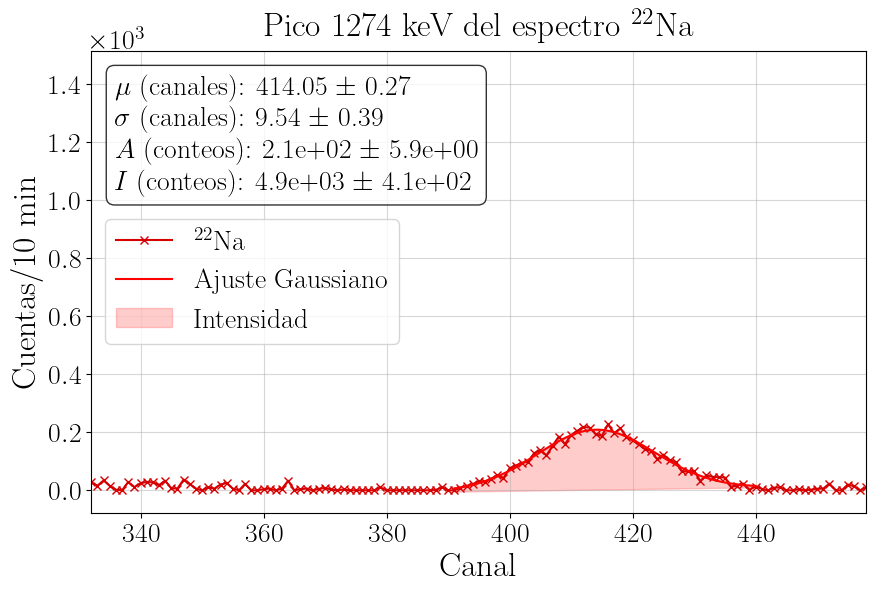

In [15]:
# Gráfica de co57
element = "na22"
params = {
    "centroid": 413,
    "sigma": 9,
    "amplitude": 207,
    "x_range": [391, 440]
}

fig, ax, param = analisis(element, params)
parametros = (
    fr"$\mu$ (canales): {param['centroid'][0]:.2f} $\pm$ {param['centroid'][1]:.2f}" + "\n"
    fr"$\sigma$ (canales): {param['sigma'][0]:.2f} $\pm$ {param['sigma'][1]:.2f}" + "\n"
    fr"$A$ (conteos): {param['amplitude'][0]:.1e} $\pm$ {param['amplitude'][1]:.1e}" + "\n"
    fr"$I$ (conteos): {param['area'][0]:.1e} $\pm$ {param['area'][1]:.1e}"
)
# Add text with a white background and rounded corners
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(0.03, 0.95, parametros, fontsize=20, color='black', fontweight='bold', transform=ax.transAxes, verticalalignment='top', bbox=bbox_props)
ax.set_title("Pico 1274 keV del espectro $^{22}$Na")
fig.savefig("peak1274_na22.pdf")
plt.show()

In [16]:
# Parámetros de calibración
a1 = un.ufloat(3.16, 0.03)  # keV/canal
a0 = un.ufloat(-40.3, 8.2)

# Valores FWHM en canales de la tabla
energia = [21, 45, 58, 179, 228, 384, 415, 433]

def canal_to_energia(canal):
    return a1 * canal + a0

# Conversión a keV
e_keV = [a1 * e + a0 for e in energia]
for i, e in enumerate(e_keV):
    print(f"Energia - pico {i+1}: {e:.2f}")

print(f"{canal_to_energia(45-21)}")


Energia - pico 1: 26.06+/-8.22
Energia - pico 2: 101.90+/-8.31
Energia - pico 3: 142.98+/-8.38
Energia - pico 4: 525.34+/-9.80
Energia - pico 5: 680.18+/-10.68
Energia - pico 6: 1173.14+/-14.14
Energia - pico 7: 1271.10+/-14.91
Energia - pico 8: 1327.98+/-15.36
36+/-8


In [17]:
# Parámetros de calibración
a1 = un.ufloat(3.16, 0.03)  # keV/canal

# Valores FWHM en canales de la tabla
fwhm_canales = [2.72, 8.17, 6.3, 13.75, 16.07, 21.55, 22.32, 22.71]

# Conversión a keV
fwhm_keV = [a1 * fwhm for fwhm in fwhm_canales]
for fwhm in fwhm_keV:
    print(f"{fwhm:.2f}")


8.60+/-0.08
25.82+/-0.25
19.91+/-0.19
43.45+/-0.41
50.78+/-0.48
68.10+/-0.65
70.53+/-0.67
71.76+/-0.68


In [18]:
# Pasar canales a energía a través de la función de calibración
def canal_to_energia(canal):
    return (a1.nominal_value * canal + a0.nominal_value)

data_energias = copy.deepcopy(data_bg)
for key, value in data_energias.items():
    df = value["file"]
    df["energia"] = canal_to_energia(df["canal"])
    data_energias[key]["file"] = df

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(data_energias["co57"]["file"]["energia"], data_energias["co57"]["file"]["cuentas"], label="Co57")
ax.set_xlim(0, 200)

(0.0, 200.0)

In [19]:
energias_teoricas = [32.8, 122.1, 136.5, 511, 661.7, 1173.2, 1274.5, 1332.5]
energias = np.sqrt(energias_teoricas)
u_FWHM = [fwhm.std_dev for fwhm in fwhm_keV]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Ajuste lineal
popt, pcov = np.polyfit(energias, FWHM, 1, cov=True)
a, b = popt
da, db = np.sqrt(np.diag(pcov))

# Generar valores ajustados
x_fit = np.linspace(min(energias), max(energias), 100)
y_fit = a * x_fit + b

# Graficar datos y ajuste
ax.plot(x_fit, y_fit, '-', color='black', label=r'$c_0 + c_1  E($keV$)^{1/2}$')
ax.errorbar(energias, FWHM, yerr=u_FWHM, fmt='none', ecolor='red', capsize=3, lw=2)
ax.plot(energias, FWHM, ".", color='blue', markersize=5)


# Añadir texto con los parámetros ajustados

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
# Calcular el coeficiente de determinación R^2
residuals = FWHM - (a * np.array(energias) + b)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((FWHM - np.mean(FWHM))**2)
r_squared = 1 - (ss_res / ss_tot)

parametros = (
    fr"Parámetros de ajuste:" + "\n"
    fr"$c_1$: {a:.2f} ± {da:.2f}" + "\n"
    fr"$c_0$: {b:.2f} ± {db:.2f}" + " keV\n"
    fr"$R^2$: {r_squared:.3f}"
)
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
ax.text(0.7, 0.03, parametros, fontsize=18, color='black', fontweight='bold', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='left', bbox=bbox_props)
ax.legend()
ax.set_xlabel("Energía (keV)")
ax.set_ylabel("FWHM (keV)")
ax.set_title("FWHM respecto Energía")
fig.savefig("FWHM.png")
plt.show()

NameError: name 'FWHM' is not defined

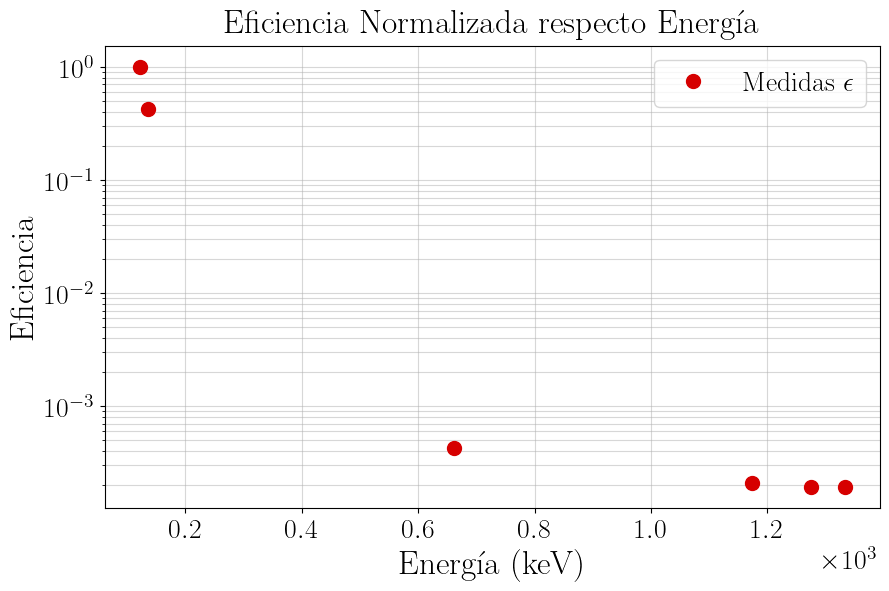

In [ ]:
# actividad
energias = [ 122.1, 136.5, 661.7, 1173.2, 1274.5, 1332.5]
eficiencia = [2.99e3, 1.28e3, 1.27e0, 6.28e-1, 5.79e-1, 5.82e-1]
# Normalizar el valor de eficiencia
eficiencia_normalizada = [x / max(eficiencia) for x in eficiencia]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(energias, eficiencia_normalizada, "o", label=r"Medidas $\epsilon$", markersize=10)
ax.set_yscale('log')
ax.set_xlabel("Energía (keV)")
ax.set_ylabel("Eficiencia")
ax.set_title("Eficiencia Normalizada respecto Energía")
ax.legend()
fig.savefig("eficiencia_normalizada.pdf")
plt.show()